<a href="https://colab.research.google.com/github/savimhl/MLPNS_MSavi/blob/main/superresolve_aenc_faces_conv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

author FBB for EthicsAI2021

# Autoencoder notebook 
create superresolution portraits from low resolution black and white images:
- load a patch of images and lower the resolution
- build an autoencoder with a bottleneck layer much smaller thn the number of pixels in an image
- pass the lower resolution images as imput and the higher resolution images as output
- ask the encoder to predict high resolution images from low resolution ones
- test it on a headshot of yourself

In [1]:
from google.colab import drive

drive.mount("/content/gdrive")


Mounted at /content/gdrive


In [24]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from keras import backend as K


In [3]:
import glob
import h5py
from PIL import Image
import numpy as np
import pylab as pl
from tqdm import tqdm_notebook as tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#cd /content/gdrive/Shareddrives/


In [4]:
cd /content/gdrive/MyDrive


/content/gdrive/MyDrive


# 1A load head shots from known training data - skip to 1B to load images already read in
The first time you will need to dowbload faces95.zip. Uncomment the 2 lines of code below

In [ ]:
# this link no longer works due to the backlash of the algorithm that whitened Obama
# but I saved the data in our shared drive
# !wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip


In [5]:
cd MLPNS2023

/content/gdrive/MyDrive/MLPNS2023


In [ ]:
!unzip faces95.zip

Archive:  faces95.zip
replace faces95/25/7.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!ls 

 data			       spm
 faces95		       spm-20210427T111354Z-001.zip
 faces95.zip		       transformer_h4_model.h5
 faces_saved.npy	      'WhatsApp Image 2023-05-10 at 17.57.53 (1).jpeg'
 imgreconstruct_100000PUS.h5  'WhatsApp Image 2023-05-10 at 17.57.53 (2).jpeg'
 imgreconstruct_10000.h5      'WhatsApp Image 2023-05-10 at 17.57.53.jpeg'
 kagglehiggs		       wine.data
 kaggleTitanic		       wine.data.1
 model.png		       wine.names
 raw.githubusercontent.com     wine.names.1


In [6]:
flist = glob.glob("faces95/*/*jpg")

In [7]:
N = len(flist)
N

1398


## read in data

if you save the data in a npy array you can read it in more quickly. After the first time you run this you can comment out the next 2 cells of code and skip to the np.load command

((70, 70, 1), 540)

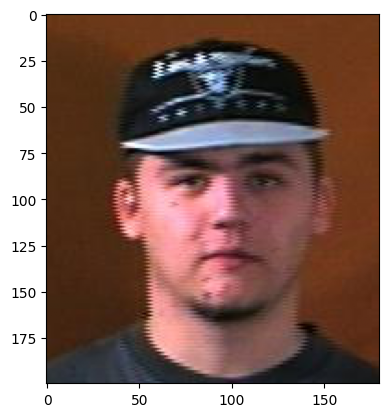

In [8]:
im = Image.open(flist[40])
np_im = numpy.array(im)[:,:,:3].astype(float) / 255 #normalize the images so that they are 0-1
pl.imshow(np_im)
# I am going to need only a subset of the image: the center part where the head is

np_im[25:165:2,25:165:2,:1].shape, np.prod(np_im.shape[1:])

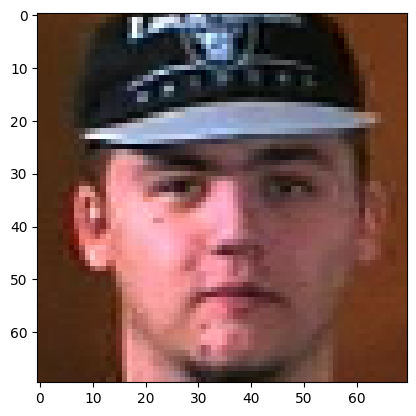

In [9]:
pl.imshow(np_im[25:165:2,25:165:2])

<font color='red'>you can skip this and go  straight to loading the images</font>

In [ ]:
#skip and read the saved version if you have saved it (after the first time you run this cell)
# I also use a single color channel (black and white)
imgs = np.zeros((N, 70, 70, 1))
for i in tqdm(range(len(flist))):
  im = Image.open(flist[i])
  np_im = numpy.array(im)[:,:,:3].astype(float) / 255 
  # here I collect the certain portion of each image 
  # from pixel 25 to 165 on the x and y axis (25:165)
  # and subsampling by a factor 2 (25:165:2)
  # and I am only choosing 1 color layer: [...,:1]: the R in RGB layers
  imgs[i] = numpy.array(im)[25:165:2,25:165:2,:1].astype(float) / 255 
#uncomment this to save another array of images - I saved the original one as data/faces.npy
#np.save("data/faces_saved.npy", imgs)

<ipython-input-112-8d7a10a391be>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm(range(len(flist))):


  0%|          | 0/1398 [00:00<?, ?it/s]

In [ ]:
np.save("faces_saved.npy", imgs)

# 1B you can read the images below if you have saved them earlier

In [10]:
imgs = np.load("faces_saved.npy")
imgs.shape

(1398, 70, 70, 1)

## 2 lower the resolution#
keep printing the shape of the images as you go along:

make a copy of the original before you lower the res 

- sample the image every other pixel to get a 35x35 image and only (the shape of the image set should be 1440,35,35,1
- create a 75/25 train/test set with the command 
          train_test_split(input, target, test_size = .25, random_state=1) 
          What are the input and output data??
- the data will be fed as a single row of pixels, so for example each imput image should be reshaped so that  the image array so that eachimage is 35*35 long: reshape the 4 arrays: input training, output training, input test and output test so that they are they are the appropriate shape (each should be Nimages x Npixel)

## Meet me at the enf of that to create the autoencoder.

In [11]:
#imgs orig is the full resolution image
imgs_orig = imgs.copy()

In [35]:
# lower the resolution
# imgs_lr = imgs[:,::2,::2]
# slightly better than the line of code above
imgs_lr = imgs.reshape(imgs.shape[0], int(imgs.shape[1]/2), 2, 
                        int(imgs.shape[2]/2), 2
                       ).mean(axis=-1).mean(axis=2)
imgs_lr.shape

(1398, 35, 35)

In [13]:
#this is the number of pixels in the image
np.prod(imgs_lr[1].shape), np.prod(imgs[1].shape), 

(1225, 4900)

#### generate a train and test set
If I want to predict the image at the same resolution I will pass the same input as the target variable. Otherwise the target variable will be a full resolution image set and the low input the lower resolution one

In [14]:
from sklearn.model_selection import train_test_split
X_tr,  X_te, y_tr, y_te = train_test_split(imgs_lr, imgs_orig, 
                                             test_size = .20, random_state=1)
  

In [15]:
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1118, 35, 35), (280, 35, 35), (1118, 70, 70, 1), (280, 70, 70, 1))

In [ ]:
#each image needs to be unravel into a flat array
#X_tr = X_tr.reshape(len(X_tr), np.prod(X_tr.shape[1:]))
#X_te = X_te.reshape(len(X_te), np.prod(X_te.shape[1:]))
#y_tr = y_tr.reshape(len(y_tr), np.prod(y_tr.shape[1:]))
#y_te = y_te.reshape(len(y_te), np.prod(y_te.shape[1:]))

In [ ]:
## important: we feed to the NN rows of pixels, not cubes of pixels
#X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((1118, 1225), (280, 1225), (1118, 4900), (280, 4900))

## 3 build an autoencoder model

Remember that the autoencoder is an hour clock model: the center is a smallest layer

for example your NN layers could be 

324 (input size) -> 256 -> 128 -> 56 -> 128 -> 256 -> 1225 (output size)

In [71]:
# this model is 324 (input size) -> 256 -> 128 128 -> 256 -> 1225 (output size)

model = Sequential()
model.add(Conv2D(512, kernel_size = (5,5), padding = "same",
                             activation = "tanh",
                             input_shape=(35, 35, 1)))
model.add(Conv2D(256, kernel_size = (5,5), padding = "same",
                             activation = "tanh",))
model.add(MaxPooling2D(pool_size=(7,7)))
model.add(Conv2D(128, kernel_size = (3,3), padding = "same",
                             activation = "tanh"))
model.add(MaxPooling2D(pool_size=(5,5)))

#upscaling

model.add(Conv2D(128, kernel_size = (3,3), padding = "same",
                             activation = "tanh"))

model.add(UpSampling2D(size = (5,5)))

model.add(Conv2D(128, kernel_size = (3,3), padding = "same",
                             activation = "tanh"))

model.add(UpSampling2D(size = (7,7)))


model.add(Conv2D(256, kernel_size = (3,3), padding = "same",
                             activation = "tanh"))

model.add(UpSampling2D(size = (2,2)))



model.add(Conv2D(1, kernel_size = (2,2), padding = "same",
                             activation = "relu"))


model.compile(optimizer='adamax', loss='mse',
              metrics=['mae', 'acc'])# optimizer="adadelta", loss="kullback_leibler_divergence")


In [72]:
print(model.summary())

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_85 (Conv2D)          (None, 35, 35, 512)       13312     
                                                                 
 conv2d_86 (Conv2D)          (None, 35, 35, 256)       3277056   
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 5, 5, 256)        0         
 g2D)                                                            
                                                                 
 conv2d_87 (Conv2D)          (None, 5, 5, 128)         295040    
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 1, 1, 128)        0         
 g2D)                                                            
                                                                 
 conv2d_88 (Conv2D)          (None, 1, 1, 128)       

## 4 A train model OR you can skip and load the pretrained I saved for you! (as long as you did not change the architecture
or to read in the saved model skip this cell, or skip the whole section and read a model from http://fbb.space/mltsa/imgreconstruct_10000.h5

In [73]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_mae',
                         patience=10,
                         min_delta=0.0001)

In [74]:
# you can skip this and load the saved model
history = model.fit( X_tr, y_tr, epochs=100000, 
                    validation_data=[X_te, y_te],
                    batch_size=16, verbose=1,
                    callbacks=[callback])
model.save("imgreconstruct_100000PUS.h5")

Epoch 1/100000
70/70 [==============================] - 8s 56ms/step - loss: 0.0414 - mae: 0.1540 - acc: 0.0019 - val_loss: 0.0328 - val_mae: 0.1396 - val_acc: 0.0035
Epoch 2/100000
70/70 [==============================] - 3s 42ms/step - loss: 0.0296 - mae: 0.1316 - acc: 0.0028 - val_loss: 0.0307 - val_mae: 0.1333 - val_acc: 0.0039
Epoch 3/100000
70/70 [==============================] - 3s 41ms/step - loss: 0.0281 - mae: 0.1269 - acc: 0.0030 - val_loss: 0.0290 - val_mae: 0.1280 - val_acc: 0.0042
Epoch 4/100000
70/70 [==============================] - 3s 43ms/step - loss: 0.0262 - mae: 0.1211 - acc: 0.0034 - val_loss: 0.0273 - val_mae: 0.1230 - val_acc: 0.0046
Epoch 5/100000
70/70 [==============================] - 3s 43ms/step - loss: 0.0250 - mae: 0.1170 - acc: 0.0034 - val_loss: 0.0265 - val_mae: 0.1205 - val_acc: 0.0045
Epoch 6/100000
70/70 [==============================] - 3s 41ms/step - loss: 0.0243 - mae: 0.1142 - acc: 0.0034 - val_loss: 0.0258 - val_mae: 0.1187 - val_acc: 0.004

In [ ]:
# READ IN THE SAVED MODEL
#!wget http://fbb.space/mltsa/imgreconstruct_10000.h5
#model.load_weights("data/imgreconstruct_10000.h5")

## predict

In [75]:
outim = model.predict(X_te)
outim

9/9 [==============================] - 1s 49ms/step


array([[[[0.23739104],
         [0.23712619],
         [0.26547256],
         ...,
         [0.29075712],
         [0.2699858 ],
         [0.2838561 ]],

        [[0.24637009],
         [0.24878111],
         [0.258231  ],
         ...,
         [0.29078194],
         [0.2758503 ],
         [0.28988546]],

        [[0.22112185],
         [0.21993616],
         [0.18238741],
         ...,
         [0.27322412],
         [0.27214035],
         [0.28279626]],

        ...,

        [[0.12901281],
         [0.08334649],
         [0.17281976],
         ...,
         [0.1809233 ],
         [0.16550925],
         [0.17957759]],

        [[0.06724352],
         [0.        ],
         [0.09718954],
         ...,
         [0.15911758],
         [0.1546963 ],
         [0.1801868 ]],

        [[0.08465189],
         [0.05104607],
         [0.14852995],
         ...,
         [0.15510117],
         [0.16230801],
         [0.16767545]]],


       [[[0.24684064],
         [0.21095467],
         [0.26

In [76]:
def compareinout(i, outim, X_tr):
  '''function to plot the input, the prediction and the target in 3 columns
  plots the ith training datum'''
  fig = pl.figure(figsize(10,5))
  ax = fig.add_subplot(131) 
  ax.imshow(X_te[i].reshape(imgs_lr[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(132) 
  ax.imshow(outim[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
  ax = fig.add_subplot(133) 
  ax.imshow(y_te[i].reshape(imgs_orig[i].shape[:2]) , cmap="bone")
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)


1 :	input		      prediction		  target


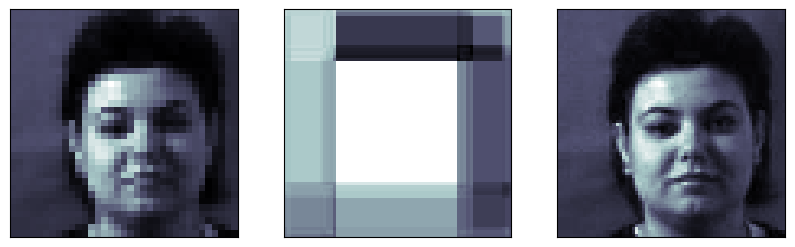

2 :	input		      prediction		  target


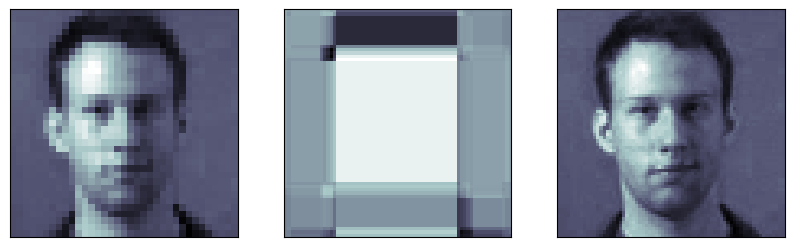

3 :	input		      prediction		  target


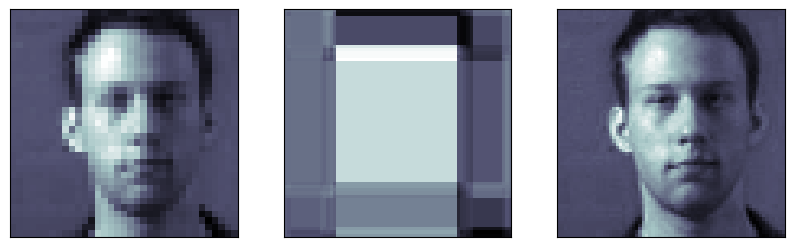

4 :	input		      prediction		  target


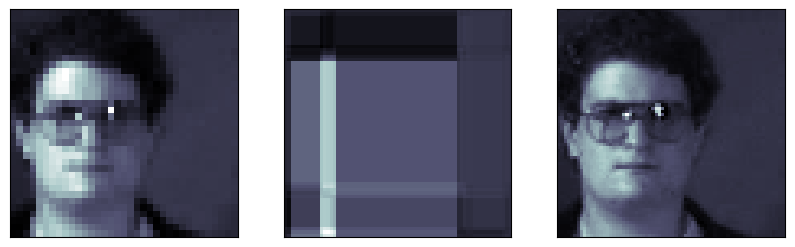

5 :	input		      prediction		  target


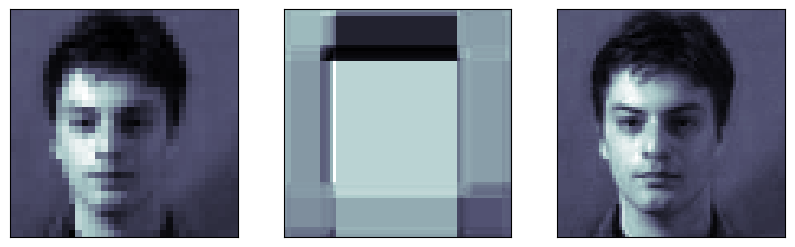

6 :	input		      prediction		  target


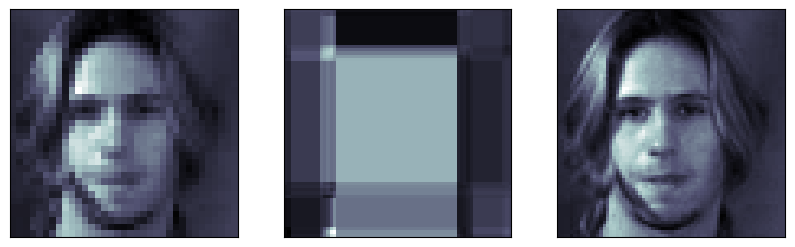

7 :	input		      prediction		  target


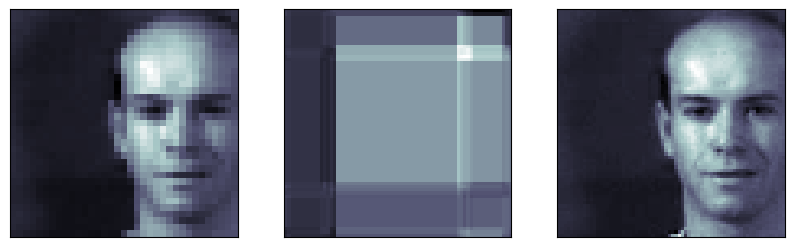

8 :	input		      prediction		  target


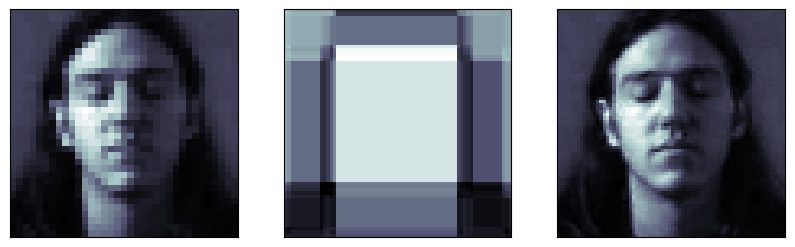

9 :	input		      prediction		  target


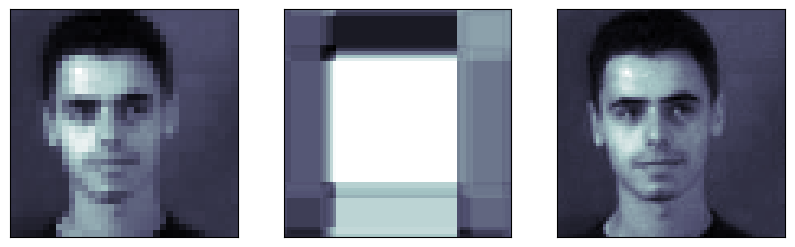

10 :	input		      prediction		  target


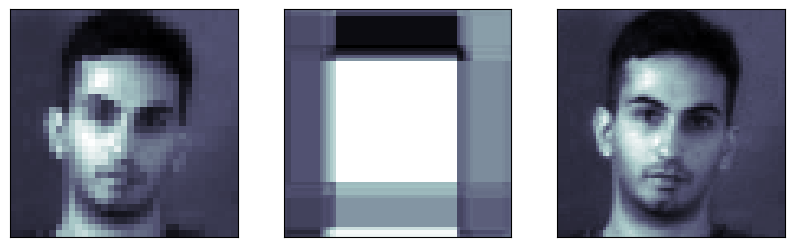

In [77]:
np.random.seed(302)
# pick a few random test images
for i in range(0, 10, 1):
  j = np.random.randint(0, len(X_te))
  print(i + 1, ":\tinput\t\t      prediction\t\t  target")
  compareinout(j, outim, X_te)
  pl.show()